# EE 461P Final Project - "Can we teach a machine ASL?"

## Imports etc.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load data
df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')

y_train = df_train['label']
X_train = df_train.drop('label', axis=1)
y_test = df_test['label']
X_test = df_test.drop('label', axis=1)

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Data Visualization/Exploration

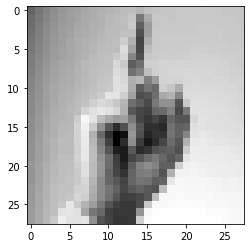

In [4]:
from PIL import Image

# display first image in training dataset
img = X_train.iloc[0].to_numpy().reshape(28,28)
letter = Image.fromarray(np.uint8(img),)

plt.figure()
plt.imshow(letter, cmap='gray')

## Classical ML - Logistic Regression

### First, we will use cross-validation and hyperparameter tuning of regularization to find the best model parameters for both l1 and l2 regularization.

In [18]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss

"""
simple cross-validation/regularization optimization to get best possible LR model
see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
"""

# l2 regularization w/ cross-entropy loss
lr_l2 = LogisticRegressionCV(penalty='l2', multi_class='multinomial', solver='saga', n_jobs=-1, tol=0.1, max_iter=10000, cv=5, scoring='neg_log_loss')
lr_l2.fit(X_train, y_train.values.ravel())

Testing cross-entropy for l2 penalty: 1.0355069730814963


In [19]:
# l1 regularization w/ cross-entropy loss
lr_l1 = LogisticRegressionCV(penalty='l1', multi_class='multinomial', solver='saga', n_jobs=-1, tol=0.1, max_iter=10000, cv=5, scoring='neg_log_loss')
lr_l1.fit(X_train, y_train.values.ravel())

Testing cross-entropy for l1 penalty: 1.0265663841359765


In [24]:
from sklearn.metrics import accuracy_score
# some model performance metrics

l2_preds = lr_l2.predict(X_test)
l1_preds = lr_l1.predict(X_test)
l2_soft_preds = lr_l2.predict_proba(X_test)
l1_soft_preds = lr_l1.predict_proba(X_test)

print(f'Cross-entropy loss on test data for l2 penalty: {log_loss(y_test, l2_soft_preds)} | for l1 penalty: {log_loss(y_test, l1_soft_preds)}')
print(f'Classification accuracy on test data for l2 penalty: {accuracy_score(y_test, l2_preds)} | for l1 penalty: {accuracy_score(y_test, l1_preds)}')

Cross-entropy loss on test data for l2 penalty: 1.0355069730814963 | for l1 penalty: 1.0265663841359765
Classification accuracy on test data for l2 penalty: 0.698968209704406 | for l1 penalty: 0.696319018404908


Not too bad for a linear model, but we can do so much better.

### Now, let's visualize the model weights as an image.

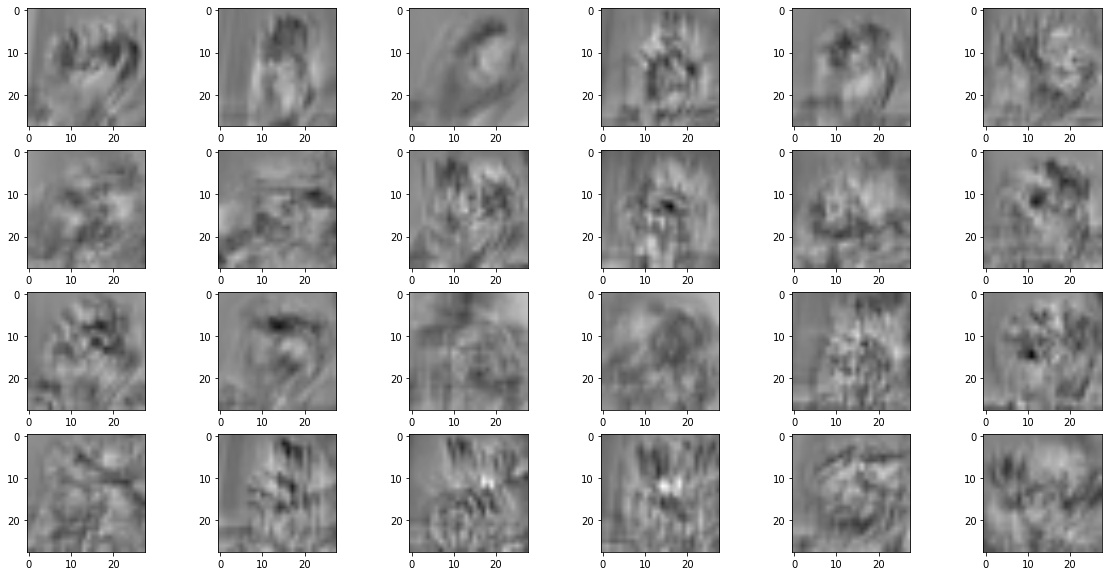

In [31]:
# display coefficients as image of same dimension

# l2 penalty coefficients
plt.figure(figsize=(20, 10))
l2_coef = lr_l2.coef_.copy()

for i in range(24):
    coef_plot = plt.subplot(4, 6, i+1)
    plt.imshow(
        l2_coef[i].reshape(28, 28),
        cmap='gray',
        vmin=-1*np.abs(l2_coef).max(),
        vmax=np.abs(l2_coef).max(),
        interpolation='bilinear'
    )

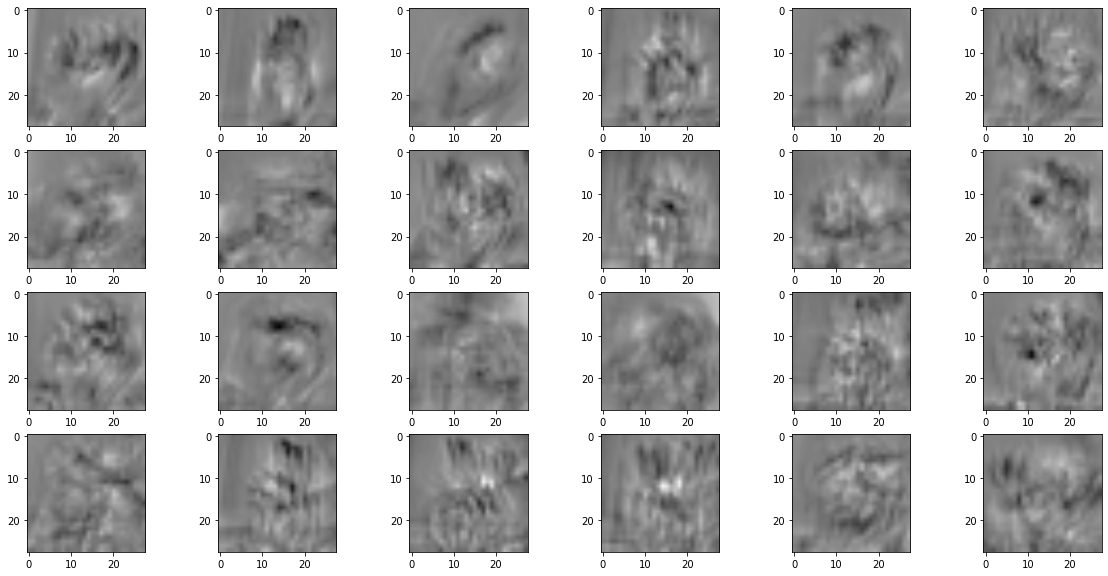

In [32]:
# l1 penalty coefficients
l1_coef = lr_l1.coef_.copy()
plt.figure(figsize=(20, 10))

for i in range(24):
    coef_plot = plt.subplot(4, 6, i+1)
    plt.imshow(
        l1_coef[i].reshape(28, 28),
        cmap='gray',
        vmin=-1*np.abs(l1_coef).max(),
        vmax=np.abs(l1_coef).max(),
        interpolation='bilinear'
    )

You can very clearly see how the model learned the various letters!

## Convolutional Neural Network - Full Implementation

Next, we'll attampt to design a rudimentary CNN with a small hidden layer and examine its performance.

In [3]:
import torch
import torch.cuda as cuda
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

"""
Data preparation - convert pd dataframes into tensors and load them into data loaders
"""

X_train_t, y_train_t = X_train.copy(), y_train.copy()
X_test_t, y_test_t = X_test.copy(), y_test.copy()

y_train_t, y_test_t = y_train_t - 1, y_test_t - 1

# X_train_t, y_train_t, X_test_t, y_test_t = map(torch.tensor, (X_train, y_train, X_test, y_test))
X_train_t, y_train_t = torch.tensor(X_train_t.values).float() / 255, torch.tensor(y_train_t.values)
X_test_t, y_test_t = torch.tensor(X_test_t.values).float() / 255, torch.tensor(y_test_t.values)
print(torch.max(y_train_t))
print(torch.max(y_test_t))

# create data loaders
batch_size = 200 # number of pictures to use per epoch
train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(X_test_t, y_test_t)
test_dl = DataLoader(test_ds, batch_size=1000) # quicker validation, can use bigger batch size

# enable GPU-accelerated training is CUDA available
if torch.cuda.is_available():
    dev = torch.device('cuda') 
    torch.cuda.empty_cache() 
else:
    dev = torch.device("cpu")


tensor(23)
tensor(23)


In [5]:
print(X_train_t.shape)
print(X_train_t[0].dtype, X_train_t[0].shape)
print(X_train_t[0])
print(torch.max(X_train_t))

torch.Size([27455, 784])
torch.float32 torch.Size([784])
tensor([0.4196, 0.4627, 0.4980, 0.5255, 0.5451, 0.5608, 0.5725, 0.5882, 0.6000,
        0.6118, 0.6196, 0.6275, 0.6392, 0.6471, 0.6235, 0.6510, 0.6588, 0.6667,
        0.6667, 0.6706, 0.6706, 0.6706, 0.6745, 0.6706, 0.6706, 0.6667, 0.6667,
        0.6627, 0.4353, 0.4745, 0.5059, 0.5294, 0.5529, 0.5647, 0.5804, 0.5922,
        0.6039, 0.6157, 0.6275, 0.6392, 0.6431, 0.6667, 0.4667, 0.5961, 0.6706,
        0.6706, 0.6667, 0.6706, 0.6745, 0.6745, 0.6745, 0.6745, 0.6745, 0.6706,
        0.6706, 0.6667, 0.4431, 0.4824, 0.5137, 0.5373, 0.5569, 0.5686, 0.5882,
        0.5961, 0.6078, 0.6196, 0.6314, 0.6392, 0.6431, 0.6745, 0.4118, 0.5569,
        0.6667, 0.6706, 0.6706, 0.6706, 0.6745, 0.6745, 0.6784, 0.6784, 0.6745,
        0.6706, 0.6706, 0.6706, 0.4549, 0.4902, 0.5216, 0.5451, 0.5608, 0.5725,
        0.5922, 0.6000, 0.6118, 0.6235, 0.6353, 0.6392, 0.6549, 0.6549, 0.3725,
        0.5647, 0.6706, 0.6745, 0.6745, 0.6745, 0.6745, 0.6745,

In [5]:
# define our model
class MNist_Net(nn.Module):
    def __init__(self):
        super(MNist_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 24, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
#         x = F.avg_pool2d(x, 4)
        return F.log_softmax(x)

# create model, send to appropriate device
cnn = MNist_Net()
cnn.to(dev)

# hyperparameters - learning rate, momentum
lr, momentum = 0.1, 0.9

# optimizer is stochastic gradient descent
opt = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)

In [6]:
# create our main training loop
def train(cnn, epoch, train_dl, test_dl, dev, train_loss, train_acc, valid_loss, valid_acc):
    cnn.train()

    running_loss = 0
    correct = 0
    total = 0

    for data, target in train_dl:
        data = data.to(dev)
        # target = target.long()
        target = target.to(dev)

        opt.zero_grad() # zero out gradients (pytorch accumulates by default)
        output = cnn(data)
        loss = -1*output[range(target.shape[0]), target].mean()
        loss.backward()
        opt.step()

        running_loss += loss.item()
        # _, predicted = output.max(1)
        pred = output.data.max(1, keepdim=True)[1] # what does the model predict?
        correct += pred.eq(target.data.view_as(pred)).sum().item() # was the model correct?

    loss = running_loss / len(train_dl.dataset)
    acc = 100.*correct / len(train_dl.dataset)
    train_loss.append(loss)
    train_acc.append(acc)

    print(f'Train results for Epoch {epoch+1} --> Loss: {loss} | Accuracy: {acc}')

    cnn.eval()

    correct = 0
    with torch.no_grad():
        for data, target in test_dl:
            data = data.to(dev)
            # target = target.long()
            target = target.to(dev)
            output = cnn(data)
            loss += -1*output[range(target.shape[0]), target].mean().item()
            pred = output.data.max(1, keepdim=True)[1] # what does the model predict?
            correct += pred.eq(target.data.view_as(pred)).sum().item() # was the model correct?

            loss /= len(test_dl.dataset)
        acc = 100*correct / len(test_dl.dataset)
        valid_acc.append(acc)
        valid_loss.append(loss)

        print(f'Test results for Epoch {epoch+1} --> Loss: {loss} | Accuracy: {acc}')

In [7]:
# do the training
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []

for epoch in range(15):
    train(cnn, epoch, train_dl, test_dl, dev, train_loss, train_acc, valid_loss, valid_acc)

C:\Users\pierc\AppData\Local\Temp\ipykernel_10744\738829089.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train results for Epoch 1 --> Loss: 0.01538781466715932 | Accuracy: 9.54288836277545
Test results for Epoch 1 --> Loss: 0.0004132254627547168 | Accuracy: 16.56441717791411
Train results for Epoch 2 --> Loss: 0.012632009293120798 | Accuracy: 28.95283190675651
Test results for Epoch 2 --> Loss: 0.0003581715439380129 | Accuracy: 27.384272169548243
Train results for Epoch 3 --> Loss: 0.008837832859187282 | Accuracy: 49.7395738481151
Test results for Epoch 3 --> Loss: 0.00029363311244316845 | Accuracy: 44.199665365309535
Train results for Epoch 4 --> Loss: 0.007492632024428424 | Accuracy: 56.83846293935531
Test results for Epoch 4 --> Loss: 0.0002981007258861795 | Accuracy: 46.137757947573895
Train results for Epoch 5 --> Loss: 0.00741416992461219 | Accuracy: 57.29375341467856
Test results for Epoch 5 --> Loss: 0.00031222386993513444 | Accuracy: 45.41271611823759
Train results for Epoch 6 --> Loss: 0.007407840056793652 | Accuracy: 57.30832270988891
Test results for Epoch 6 --> Loss: 0.00031

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf(model, loader, dev):
    # iterate over test data
    y_pred = []
    y_true = []
    for inputs, labels in loader:
            model.eval()
            inputs, labels = inputs.to(dev), labels.to(dev)
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            # output = np.squeeze(output, axis=2)
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    return y_pred, y_true


In [8]:
print(train_acc)
print(valid_acc)
data = {'training_loss': train_loss, 'training_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}
df = pd.DataFrame(data)
df.index.name = 'epoch'
df.to_csv('training_data_model1_bad_lr_0.1.csv')

[9.54288836277545, 28.95283190675651, 49.7395738481151, 56.83846293935531, 57.29375341467856, 57.30832270988891, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149, 57.31196503369149]
[16.56441717791411, 27.384272169548243, 44.199665365309535, 46.137757947573895, 45.41271611823759, 45.99832682654768, 45.87283881762409, 45.99832682654768, 46.137757947573895, 46.09592861126603, 46.207473508087006, 46.24930284439487, 46.137757947573895, 46.47239263803681, 46.24930284439487]


In [13]:
# serialize & save model weights
torch.save(cnn.state_dict(), 'model2.pth')

In [5]:
class MNist_Net2(nn.Module):
    def __init__(self):
        super(MNist_Net2, self).__init__()
        self.cov = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6272,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,24)
        )
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.cov(x)
        x = self.linear(x)
        return F.log_softmax(x)

In [8]:
# create model, send to appropriate device
cnn2 = MNist_Net2()
cnn2.to(dev)

# hyperparameters - learning rate, momentum
lr, momentum = 0.01, 0.9

# optimizer is stochastic gradient descent
opt = optim.SGD(cnn2.parameters(), lr=lr, momentum=momentum)

# do the training
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []
for epoch in range(10):
    train(cnn2, epoch, train_dl, test_dl, dev, train_loss, train_acc, valid_loss, valid_acc)

C:\Users\pierc\AppData\Local\Temp\ipykernel_10776\707739629.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train results for Epoch 1 --> Loss: 0.0027371306581233743 | Accuracy: 83.69331633582226
Test results for Epoch 1 --> Loss: 1.4867401415901263e-05 | Accuracy: 91.25766871165644
Train results for Epoch 2 --> Loss: 3.016349040155006e-05 | Accuracy: 95.8987433982881
Test results for Epoch 2 --> Loss: 9.597895000796651e-06 | Accuracy: 91.66201896263246
Train results for Epoch 3 --> Loss: 1.4246632810597253e-05 | Accuracy: 95.8987433982881
Test results for Epoch 3 --> Loss: 8.564464142837802e-06 | Accuracy: 91.63413273842721
Train results for Epoch 4 --> Loss: 9.230373659127235e-06 | Accuracy: 95.8987433982881
Test results for Epoch 4 --> Loss: 7.449537107334809e-06 | Accuracy: 92.10819854991634
Train results for Epoch 5 --> Loss: 6.759637219031133e-06 | Accuracy: 95.8987433982881
Test results for Epoch 5 --> Loss: 7.5632954013563525e-06 | Accuracy: 91.95482431678751
Train results for Epoch 6 --> Loss: 5.340523783920122e-06 | Accuracy: 95.8987433982881
Test results for Epoch 6 --> Loss: 6.71

In [9]:
data = {'training_loss': train_loss, 'training_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}
df = pd.DataFrame(data)
df.index.name = 'epoch'
df.to_csv('training_data_model2.csv')

In [32]:
torch.save(cnn2.state_dict(), 'model3.pth')

In [10]:
class MNist_Net3(nn.Module):
    def __init__(self):
        super(MNist_Net3, self).__init__()
        self.cov = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,24)
        )
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.cov(x)
        x = self.linear(x)
        return F.log_softmax(x)

In [11]:
# create model, send to appropriate device
cnn3 = MNist_Net3()
cnn3.to(dev)

# hyperparameters - learning rate, momentum
lr, momentum = 0.01, 0.9

# optimizer is stochastic gradient descent
opt = optim.SGD(cnn3.parameters(), lr=lr, momentum=momentum)

# do the training
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []
for epoch in range(10):
    train(cnn3, epoch, train_dl, test_dl, dev, train_loss, train_acc, valid_loss, valid_acc)

C:\Users\pierc\AppData\Local\Temp\ipykernel_10776\3426742315.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train results for Epoch 1 --> Loss: 0.0030426246319471585 | Accuracy: 82.07248224367146
Test results for Epoch 1 --> Loss: 1.3507186900718863e-05 | Accuracy: 91.59230340211936
Train results for Epoch 2 --> Loss: 2.6095769651528592e-05 | Accuracy: 95.8987433982881
Test results for Epoch 2 --> Loss: 9.656570852458869e-06 | Accuracy: 92.15002788622421
Train results for Epoch 3 --> Loss: 1.2595665588041425e-05 | Accuracy: 95.8987433982881
Test results for Epoch 3 --> Loss: 8.268332415614824e-06 | Accuracy: 92.28945900725041
Train results for Epoch 4 --> Loss: 8.280016409792582e-06 | Accuracy: 95.8987433982881
Test results for Epoch 4 --> Loss: 7.992999449343823e-06 | Accuracy: 92.49860568878974
Train results for Epoch 5 --> Loss: 6.0613526010513035e-06 | Accuracy: 95.8987433982881
Test results for Epoch 5 --> Loss: 7.512289192820094e-06 | Accuracy: 92.66592303402119
Train results for Epoch 6 --> Loss: 4.864413117960386e-06 | Accuracy: 95.8987433982881
Test results for Epoch 6 --> Loss: 7.1

In [12]:
data = {'training_loss': train_loss, 'training_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}
df = pd.DataFrame(data)
df.index.name = 'epoch'
df.to_csv('training_data_model3.csv')

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred, y_true = conf(cnn3, test_dl, dev)
classes = ('a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y')

cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
df_cm = pd.DataFrame(np.round(cf_matrix/np.sum(cf_matrix) *10, 2), index = [i for i in classes],
                     columns = [i for i in classes])

# I have no idea why the first row is offset but I can't be bothered to fix it
df_cm.iloc[0,0] = 0.46
df_cm.iloc[0,23] = 0

C:\Users\pierc\AppData\Local\Temp\ipykernel_10776\3426742315.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


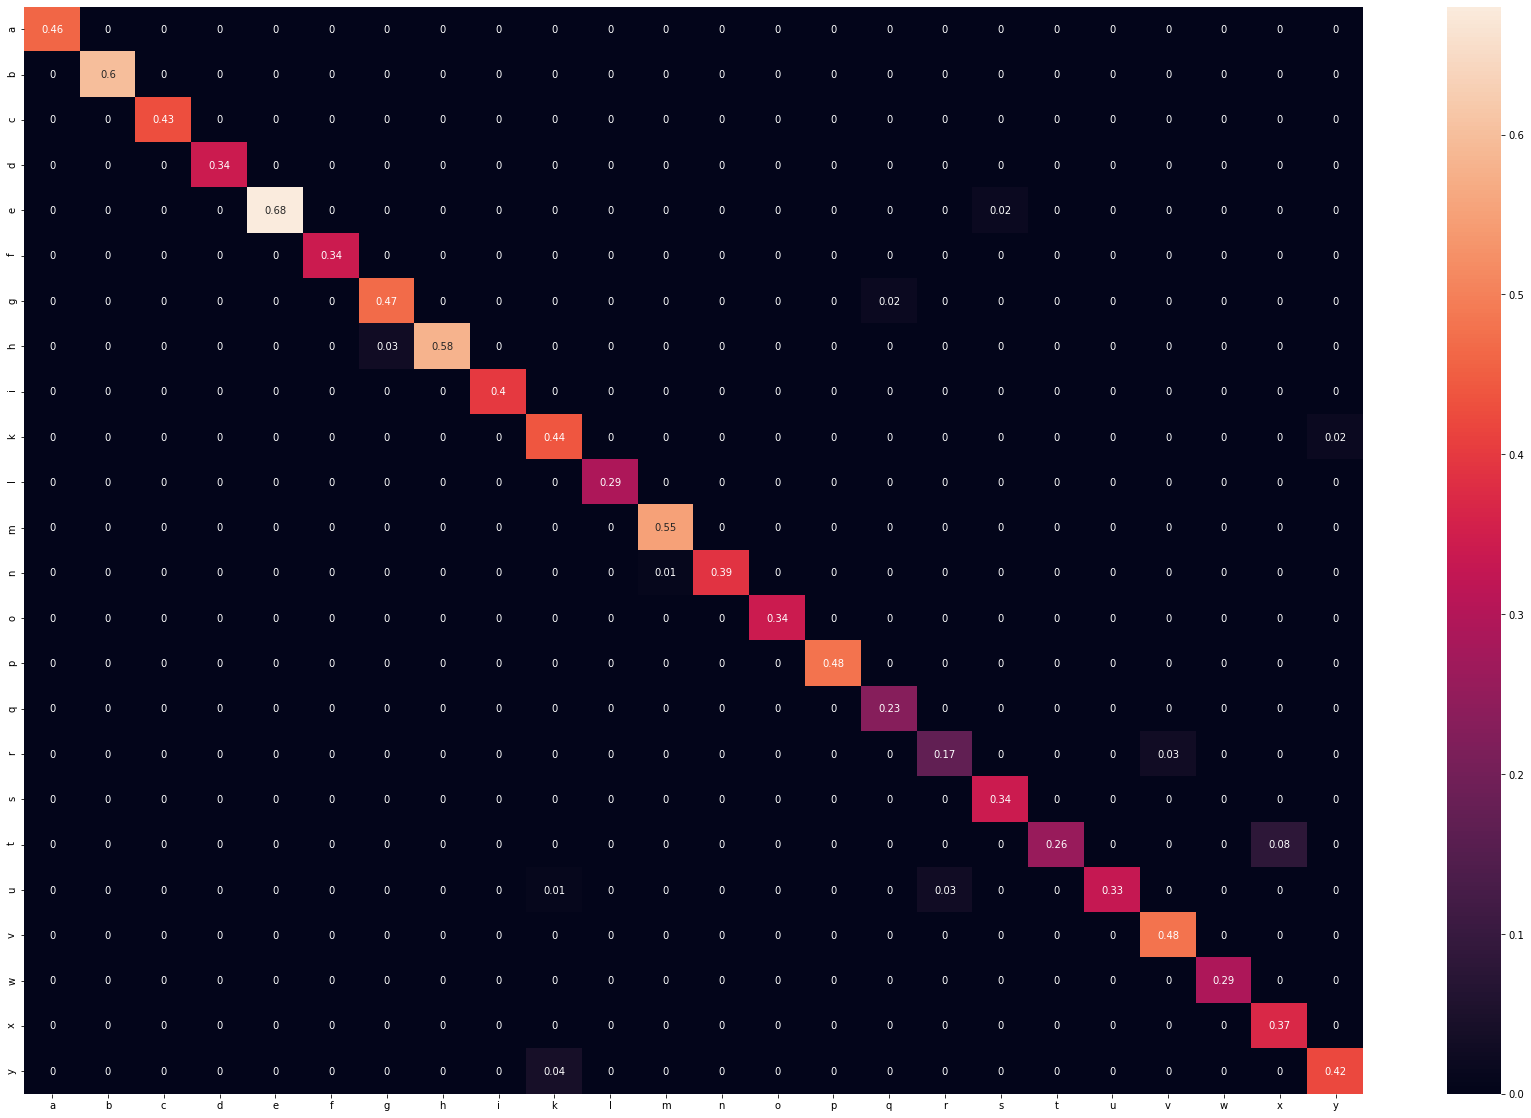

In [28]:

plt.figure(figsize = (30,20))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [51]:
torch.save(cnn3.state_dict(), 'model4.pth')